# Percentile Analysis

In [82]:
import sys

import numpy as np
from matplotlib import pylab as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns

sys.path.append("..")
from constants import MIN_DAYSAHEAD, MAX_DAYSAHEAD, BIN_FREQ_PER_DAY

sns.set()

# Load Data Frames from Disk

In [83]:
df = pd.DataFrame()
df_baseline = pd.DataFrame()

for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1):
    # Load model dataframe
    df_cur = pd.read_csv(
        f"../data/processed/skew_gaussian/k200/delta_window8/percentiles_daysahead{i}_R000.csv"
    )
    df["TruePercentile"] = df_cur["TruePercentile"]
    df[f"{i} Days"] = df_cur["ObservedPercentile"]

    # Load baseline dataframe
    df_cur = pd.read_csv(
        f"../data/processed/baseline/percentiles_daysahead{i}_R000.csv"
    )
    df_baseline["TruePercentile"] = df_cur["TruePercentile"]
    df_baseline[f"{i} Days"] = df_cur["ObservedPercentile"]

In [84]:
df

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,5.4,5.3,5.1,5.1,5.5,5.5,5.2
2,10,10.6,10.8,9.9,10.3,10.5,10.7,10.4
3,15,15.9,15.9,15.1,15.4,15.5,16.1,15.5
4,20,21.0,21.0,20.3,20.4,20.9,21.2,20.3
5,25,26.1,26.0,25.4,25.6,26.1,26.2,25.2
6,30,31.4,30.8,30.3,31.0,31.4,31.1,30.2
7,35,36.6,35.7,34.9,35.9,36.2,36.2,35.3
8,40,41.5,40.8,40.0,40.9,41.0,41.4,40.0
9,45,46.7,45.8,44.9,45.8,46.0,46.2,44.6


In [85]:
df_baseline

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,6.4,6.4,6.4,6.1,6.5,6.5,6.6
2,10,12.4,12.6,12.4,12.8,12.9,12.7,13.4
3,15,18.2,18.6,18.9,19.0,19.1,19.1,19.4
4,20,23.9,24.5,24.3,24.9,25.3,25.2,25.8
5,25,30.2,30.2,30.5,31.1,31.6,31.3,31.8
6,30,35.6,36.1,36.2,36.7,37.5,37.0,37.9
7,35,41.1,41.4,42.1,42.3,42.8,42.4,43.5
8,40,46.3,46.6,47.7,47.5,48.5,48.0,48.6
9,45,51.0,51.4,52.7,52.5,53.4,53.0,53.5


# Model Results

In [86]:
pd.set_option("display.float_format", "{:.1f}".format)
df[df.TruePercentile.apply(lambda x: x in [25, 50, 75])]

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
5,25,26.1,26.0,25.4,25.6,26.1,26.2,25.2
10,50,51.7,50.7,49.7,50.5,51.2,51.2,49.5
15,75,75.6,74.2,73.9,74.6,74.8,74.9,71.8


In [87]:
df_err = pd.DataFrame(
    {
        f"{i} Days": df["TruePercentile"] - df[f"{i} Days"]
        for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1)
    }
)
df_err

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.4,-0.3,-0.1,-0.1,-0.5,-0.5,-0.2
2,-0.6,-0.8,0.1,-0.3,-0.5,-0.7,-0.4
3,-0.9,-0.9,-0.1,-0.4,-0.5,-1.1,-0.5
4,-1.0,-1.0,-0.3,-0.4,-0.9,-1.2,-0.3
5,-1.1,-1.0,-0.4,-0.6,-1.1,-1.2,-0.2
6,-1.4,-0.8,-0.3,-1.0,-1.4,-1.1,-0.2
7,-1.6,-0.7,0.1,-0.9,-1.2,-1.2,-0.3
8,-1.5,-0.8,0.0,-0.9,-1.0,-1.4,-0.0
9,-1.7,-0.8,0.1,-0.8,-1.0,-1.2,0.4


# Baseline Results

In [88]:
df_baseline[df_baseline.TruePercentile.apply(lambda x: x in [25, 50, 75])]

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
5,25,30.2,30.2,30.5,31.1,31.6,31.3,31.8
10,50,55.7,56.1,57.2,57.1,58.3,57.5,58.0
15,75,77.2,77.9,78.0,77.9,78.2,78.3,77.2


In [89]:
df_baseline_err = pd.DataFrame(
    {
        f"{i} Days": df_baseline["TruePercentile"] - df_baseline[f"{i} Days"]
        for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1)
    }
)

In [90]:
df_baseline_err

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.4,-1.4,-1.4,-1.1,-1.5,-1.5,-1.6
2,-2.4,-2.6,-2.4,-2.8,-2.9,-2.7,-3.4
3,-3.2,-3.6,-3.9,-4.0,-4.1,-4.1,-4.4
4,-3.9,-4.5,-4.3,-4.9,-5.3,-5.2,-5.8
5,-5.2,-5.2,-5.5,-6.1,-6.6,-6.3,-6.8
6,-5.6,-6.1,-6.2,-6.7,-7.5,-7.0,-7.9
7,-6.1,-6.4,-7.1,-7.3,-7.8,-7.4,-8.5
8,-6.3,-6.6,-7.7,-7.5,-8.5,-8.0,-8.6
9,-6.0,-6.4,-7.7,-7.5,-8.4,-8.0,-8.5


# Comparison Plot 

In [91]:
def make_plot(df_plot, title, ax):
    for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1):
        ax.plot(df_plot.TruePercentile, df_plot[f"{i} Days"], "o-", label=f"{i} Days")
    ax.plot(
        df_plot.TruePercentile,
        df_plot.TruePercentile,
        color="red",
        label="Identity",
        linestyle="dashed",
    )
    ax.legend().set_title("Days Ahead")
    ax.set_xlabel("True Percentile")
    ax.set_ylabel("Observed Percentile")
    ax.set_xlim(0, 101)
    ax.set_ylim(0, 101)
    ax.set_yticklabels([str(p) + "%" for p in ax.get_xticks()])
    ax.set_xticklabels([str(p) + "%" for p in ax.get_xticks()])
    ax.set_title(title)

/tmp/ipykernel_3071853/1222667534.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(p) + "%" for p in ax.get_xticks()])
/tmp/ipykernel_3071853/1222667534.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(p) + "%" for p in ax.get_xticks()])


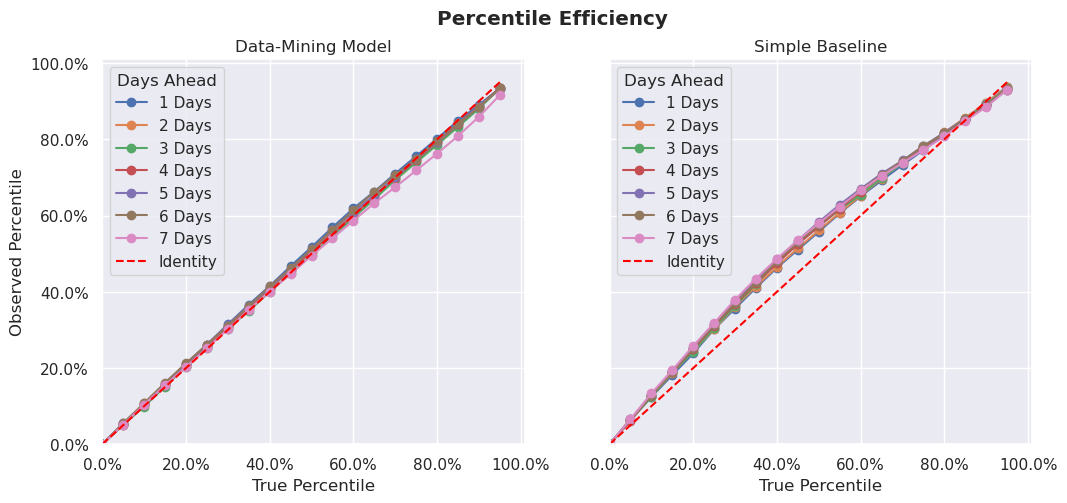

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

make_plot(df, "Data-Mining Model", axes[0])
make_plot(df_baseline, "Simple Baseline", axes[1])
axes[1].set_ylabel("")
plt.suptitle("Percentile Efficiency", fontweight="bold")
plt.savefig("../plots.percentile_efficiency.png", dpi=300)

In [93]:
np.abs(df_baseline_err) - np.abs(df_err)

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.1,1.3,1.0,1.0,1.0,1.4
2,1.8,1.8,2.2,2.5,2.4,1.9,2.9
3,2.3,2.8,3.7,3.6,3.6,2.9,4.0
4,2.8,3.6,4.0,4.5,4.4,4.0,5.5
5,4.0,4.1,5.1,5.5,5.5,5.1,6.6
6,4.2,5.3,5.9,5.8,6.0,5.9,7.8
7,4.5,5.6,7.0,6.3,6.6,6.3,8.2
8,4.8,5.8,7.6,6.5,7.5,6.6,8.6
9,4.3,5.6,7.5,6.7,7.4,6.8,8.2
